In [ ]:
import os
import imageio
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 경로 설정
excel_file_path = r""
data_dir = r""

# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

In [2]:
print(df['CDR'].unique())

[0.  0.5 nan 1.  2. ]


In [3]:
# CDR 값이 2인 행 필터링
cdr_2_rows = df[df['CDR'] == 2]
print(cdr_2_rows)

                ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
278  OAS1_0308_MR1   F    R   78   3.0  3.0  15.0  2.0  1401  0.703  1.253   
317  OAS1_0351_MR1   M    R   86   1.0  4.0  15.0  2.0  1512  0.665  1.161   

     Delay  
278    NaN  
317    NaN  


In [14]:
print(sum(df['CDR'] == 0), sum(df['CDR'] == 1))

135 28


In [2]:
## 1. 결측값 제거
####################################
# CDR 값이 없는 경우, 결측값으로 간주하고 제거
df = df.dropna(subset=['CDR'])

# MRI, label, 인구통계 정보를 위한 리스트와 딕셔너리 생성
coronal_images = {}
sagittal_images = {}
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []
demographics = {}

# 이미지 크기 조정 함수 정의 (이미지를 224x224로 변환)
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]  # 2D 이미지이므로 앞의 두 차원만 사용
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)]
    return zoom(image, zoom_factors)

# 피험자 데이터 로드 및 저장
for disc_num in range(1, 13):  # 1~12 디스크 (OASIS 디스크 12개)
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")

    # [디버깅] 디스크 경로가 존재하는지 확인
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue

    for sub_folder in os.listdir(disc_path):  # disc 안의 폴더 탐색
        sub_folder_path = os.path.join(disc_path, sub_folder)

        if not os.path.isdir(sub_folder_path):  # [디버깅] 폴더가 아닌 경우 무시
            print(f"Skipping non-directory: {sub_folder_path}")
            continue

        for subject_dir in os.listdir(sub_folder_path):  # 피험자 폴더 탐색
            subject_path = os.path.join(sub_folder_path, subject_dir)

            if not os.path.isdir(subject_path): # [디버깅] 폴더가 아닌 경우 무시
                print(f"Skipping non-directory: {subject_path}")
                continue

            # MR1 경로 설정
            session_path = subject_path
            print(f"Processing session: {session_path}")

            if not os.path.exists(session_path): # [디버깅]
                print(f"Session path does not exist: {session_path}")
                continue

            # preprocessed 데이터 경로 (T88_111 폴더)
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            print(f"Checking T88_111 path: {t88_111_path}")

            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # coronal 이미지 처리
                    if file.endswith("_cor_110.gif"):
                        print(f"Loading coronal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            coronal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading coronal image: {e}")

                    # sagittal 이미지 처리
                    elif file.endswith("_sag_95.gif"):
                        print(f"Loading sagittal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)
                            sagittal_images[subject_dir] = img_resized
                        except Exception as e: # [디버깅]
                            print(f"Error loading sagittal image: {e}")

                    # transverse 이미지 처리
                    elif file.endswith("_tra_90.gif"):
                        if "masked_gfc" in file:
                            print(f"Loading masked transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_masked[subject_dir] = img_resized
                            except Exception as e: # [디버깅]
                                print(f"Error loading masked transverse image: {e}")
                        else:
                            print(f"Loading regular transverse .gif file: {file_path}")
                            try:
                                img = imageio.v2.imread(file_path)
                                img_resized = resize_image(img)
                                transverse_images_gfc[subject_dir] = img_resized
                            except Exception as e: #[디버깅]
                                print(f"Error loading regular transverse image: {e}")

                    # 피험자 ID 그대로 추출
                    subject_id = subject_dir

                    # 엑셀에서 해당 ID를 매칭하고 정보를 찾기
                    subject_info = df[df['ID'] == subject_id]

                    if not subject_info.empty:
                        # CDR 값을 label로 사용
                        cdr_value = subject_info['CDR'].values[0]
                        labels.append(cdr_value)

                        # 인구통계학적 정보 딕셔너리에 저장
                        demographics[subject_id] = {
                            'M/F': subject_info['M/F'].values[0],
                            'Hand': subject_info['Hand'].values[0],
                            'Age': subject_info['Age'].values[0],
                            'Educ': subject_info['Educ'].values[0],
                            'SES': subject_info['SES'].values[0],
                            'MMSE': subject_info['MMSE'].values[0],
                            'eTIV': subject_info['eTIV'].values[0],
                            'nWBV': subject_info['nWBV'].values[0],
                            'ASF': subject_info['ASF'].values[0],
                            'Delay': subject_info['Delay'].values[0]
                        }
                    else:
                        pass #print(f"Label not found for subject: {subject_id}")  # label이 없는 피험자 출력
            else:
                pass #print(f"T88_111 path does not exist: {t88_111_path}")

# 결측값 처리: label와 mri가 동시에 존재하는 피실험자만 데이터셋으로 사용하기
valid_subjects = [subject for subject in demographics if subject in df['ID'].values]
coronal_images = {subject: coronal_images[subject] for subject in valid_subjects if subject in coronal_images}
sagittal_images = {subject: sagittal_images[subject] for subject in valid_subjects if subject in sagittal_images}
transverse_images_gfc = {subject: transverse_images_gfc[subject] for subject in valid_subjects if subject in transverse_images_gfc}
transverse_images_masked = {subject: transverse_images_masked[subject] for subject in valid_subjects if subject in transverse_images_masked}
labels = [df[df['ID'] == subject]['CDR'].values[0] for subject in valid_subjects]

# 1차 최종 정보 출력
print(f"Coronal images: {len(coronal_images)}")
print(f"Sagittal images: {len(sagittal_images)}")
print(f"Regular transverse images: {len(transverse_images_gfc)}")
print(f"Masked transverse images: {len(transverse_images_masked)}")
print(f"총 label: {len(labels)}")
print(f"저장된 피험자 수: {len(demographics)}")

####################################
## 2. Label 인코딩
####################################
def convert_images_to_array(image_dict):
    image_array = []
    for img in image_dict.values():
        # 이미지가 흑백인 경우 : 채널을 추가하고 3채널로 변환
        if len(img.shape) == 2:  # 흑백 이미지 (height, width)
            img = np.expand_dims(img, axis=-1)  # (height, width) -> (height, width, 1)
            img = np.repeat(img, 3, axis=-1)  # (height, width, 1) -> (height, width, 3) # 오류 시, 제거
        image_array.append(img)
    return np.array(image_array)

# 각 그룹별로 인원수 계산
dementia_count = sum([1 for cdr in labels if cdr >= 1])  # 치매군: CDR 값이 1 이상인 경우
mild_dementia_count = sum([1 for cdr in labels if cdr == 0.5])  # 경도 치매군: CDR 값이 0.5인 경우
non_dementia_count = sum([1 for cdr in labels if cdr == 0])  # 비치매군: CDR 값이 0인 경우
print(f"Total Dementia: {dementia_count}, Total Mild Dementia: {mild_dementia_count}, Total Non-dementia: {non_dementia_count}")

# 비치매군과 경도치매군을 치매군의 개수에 맞게 랜덤 추출 (과적합 방지를 위해 / 치매군: 30)
non_dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr == 0]
np.random.seed(42)
non_dementia_subjects_balanced = np.random.choice(non_dementia_subjects, size=mild_dementia_count, replace=False).tolist()

mild_dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr == 0.5]
#np.random.seed(42)
#mild_dementia_subjects_balanced = np.random.choice(mild_dementia_subjects, size=dementia_count, replace=False).tolist()

# 치매군, 경도치매군과 밸런스를 맞춘 비치매군의 데이터셋을 합침
dementia_subjects = [subject for subject, cdr in zip(valid_subjects, labels) if cdr >= 1]
balanced_subjects = dementia_subjects + mild_dementia_subjects + non_dementia_subjects_balanced

# label 설정: 1은 치매, 0.5는 경도치매, 0은 비치매
balanced_labels = [2] * len(dementia_subjects) + [1] * len(mild_dementia_subjects) + [0] * len(non_dementia_subjects_balanced)
print(f"Balanced dataset subjects: {len(balanced_subjects)}, Labels: {len(balanced_labels)}")

####################################
## 3. 데이터셋 분리
####################################
# 데이터셋을 train/validation/test로 분할
train_subjects, temp_subjects, train_labels, temp_labels = train_test_split(
    balanced_subjects, balanced_labels, test_size=0.4, stratify=balanced_labels, random_state=42
)

val_subjects, test_subjects, val_labels, test_labels = train_test_split(
    temp_subjects, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# 각 세트에 맞는 이미지들 준비 (coronal, sagittal, transverse, transverse_masked)
train_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in train_subjects if subject in coronal_images})
val_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in val_subjects if subject in coronal_images})
test_coronal = convert_images_to_array({subject: coronal_images[subject] for subject in test_subjects if subject in coronal_images})

train_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in train_subjects if subject in sagittal_images})
val_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in val_subjects if subject in sagittal_images})
test_sagittal = convert_images_to_array({subject: sagittal_images[subject] for subject in test_subjects if subject in sagittal_images})

train_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in train_subjects if subject in transverse_images_gfc})
val_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in val_subjects if subject in transverse_images_gfc})
test_transverse_gfc = convert_images_to_array({subject: transverse_images_gfc[subject] for subject in test_subjects if subject in transverse_images_gfc})

train_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in train_subjects if subject in transverse_images_masked})
val_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in val_subjects if subject in transverse_images_masked})
test_transverse_masked = convert_images_to_array({subject: transverse_images_masked[subject] for subject in test_subjects if subject in transverse_images_masked})

####################################
## 4. 정규화(Normalization)
####################################
# 정규화 함수 정의 (이미지의 픽셀 값을 0에서 1 사이로 정규화)
def normalize_image(image):
    # 이미지의 최대값이 0이 아니어야 정규화를 진행
    if image.max() > 0:
        return image / 255.0
    else:
        return image

# 정규화 적용 및 정규화 전후 값 출력 [디버깅]
def normalize_and_compare(image_array, image_type):
    print(f"Before Normalization: {image_type} Min={image_array.min()}, Max={image_array.max()}")
    normalized_images = normalize_image(image_array)
    print(f"After Normalization: {image_type} Min={normalized_images.min()}, Max={normalized_images.max()}")
    return normalized_images

# 이미지 배열에 정규화 적용
train_coronal = normalize_and_compare(train_coronal, 'Train Coronal')
val_coronal = normalize_and_compare(val_coronal, 'Validation Coronal')
test_coronal = normalize_and_compare(test_coronal, 'Test Coronal')

train_sagittal = normalize_and_compare(train_sagittal, 'Train Sagittal')
val_sagittal = normalize_and_compare(val_sagittal, 'Validation Sagittal')
test_sagittal = normalize_and_compare(test_sagittal, 'Test Sagittal')

train_transverse_gfc = normalize_and_compare(train_transverse_gfc, 'Train Transverse GFC')
val_transverse_gfc = normalize_and_compare(val_transverse_gfc, 'Validation Transverse GFC')
test_transverse_gfc = normalize_and_compare(test_transverse_gfc, 'Test Transverse GFC')

train_transverse_masked = normalize_and_compare(train_transverse_masked, 'Train Transverse Masked')
val_transverse_masked = normalize_and_compare(val_transverse_masked, 'Validation Transverse Masked')
test_transverse_masked = normalize_and_compare(test_transverse_masked, 'Test Transverse Masked')

Processing session: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1
Checking T88_111 path: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111
Loading coronal .gif file: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif
Loading sagittal .gif file: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif
Loading regular transverse .gif file: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif
Loading masked transverse .gif file: C:\Users\pc\OneDrive\바탕 화면\oasis1\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_tra_90.gif
Proces

Before Normalization & Adjustments: image Min=0.0, Max=0.7803921568627451
After Normalization Check: image Min=0.0, Max=0.7803921568627451
After All Adjustments: image Min=0.12340677254400192, Max=1.0
Before Normalization & Adjustments: image Min=0.0, Max=0.7686274509803922
After Normalization Check: image Min=0.0, Max=0.7686274509803922
After All Adjustments: image Min=0.12340677254400192, Max=1.0
Before Normalization & Adjustments: image Min=0.0, Max=0.7450980392156863
After Normalization Check: image Min=0.0, Max=0.7450980392156863
After All Adjustments: image Min=0.12340677254400192, Max=1.0


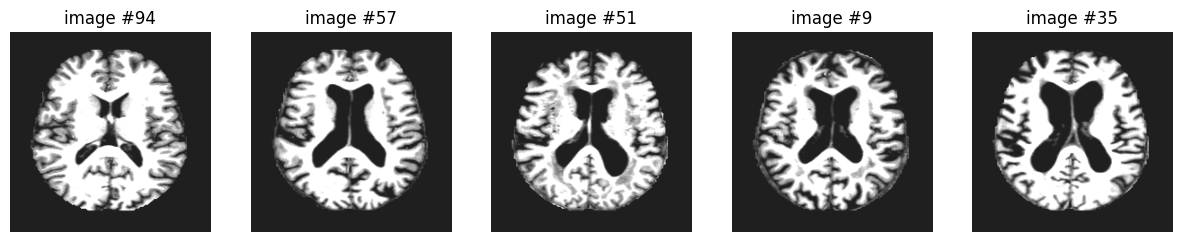

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 히스토그램 평활화 (contrast stretching) 함수
def contrast_stretching(image):
    min_val, max_val = image.min(), image.max()
    stretched_image = (image - min_val) / (max_val - min_val)
    return stretched_image

# 감마 보정 함수
def gamma_correction(image, gamma=1.0):
    gamma_corrected = np.clip(image ** gamma, 0, 1)
    return gamma_corrected

# 밝기 조정 함수
def adjust_brightness(image, brightness_factor=0.2):
    brightened_image = np.clip(image + brightness_factor, 0, 1)
    return brightened_image

# 대비 조정 함수
def enhance_contrast(image, factor=1.5):
    enhanced_image = np.clip(((image - 0.5) * factor) + 0.5, 0, 1)
    return enhanced_image

# 5개 임의의 이미지를 확인하는 함수 정의
def display_random_images(image_array, image_type, num_images=5):
    indices = random.sample(range(len(image_array)), num_images)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_array[idx])
        plt.axis('off')
        plt.title(f"{image_type} #{idx}")
    plt.show()

# 정규화, 대비 및 밝기 조정 적용 함수
def normalize_enhance(image_array, image_type, contrast_factor=1.5, brightness_factor=0.2, gamma=1.2, apply_stretch=True):
    print(f"Before Normalization & Adjustments: {image_type} Min={image_array.min()}, Max={image_array.max()}")

    # 이미지가 이미 정규화된 경우(0~1 범위), 추가 정규화 생략
    if image_array.max() > 1:
        normalized_images = image_array / 255.0
    else:
        normalized_images = image_array  # 이미 정규화된 경우 그대로 사용

    print(f"After Normalization Check: {image_type} Min={normalized_images.min()}, Max={normalized_images.max()}")

    # 히스토그램 평활화(contrast stretching) 적용
    if apply_stretch:
        stretched_images = np.array([contrast_stretching(img) for img in normalized_images])
    else:
        stretched_images = normalized_images

    # 대비 조정 및 밝기 조정 적용
    enhanced_images = np.array([enhance_contrast(img, factor=contrast_factor) for img in stretched_images])
    brightened_images = np.array([adjust_brightness(img, brightness_factor=brightness_factor) for img in enhanced_images])

    # 감마 보정 적용
    gamma_corrected_images = np.array([gamma_correction(img, gamma=gamma) for img in brightened_images])

    print(f"After All Adjustments: {image_type} Min={gamma_corrected_images.min()}, Max={gamma_corrected_images.max()}")
    return gamma_corrected_images

# 데이터셋에 적용 (train_coronal을 대상으로 예시)
enhanced_brightebed_train = normalize_enhance(train_transverse_masked, "image", contrast_factor=1.5, brightness_factor=0.2, gamma=1.3, apply_stretch=True)
enhanced_brightebed_val = normalize_enhance(val_transverse_masked, "image", contrast_factor=1.5, brightness_factor=0.2, gamma=1.3, apply_stretch=True)
enhanced_brightebed_test = normalize_enhance(test_transverse_masked, "image", contrast_factor=1.5, brightness_factor=0.2, gamma=1.3, apply_stretch=True)

# 임의의 5개 이미지 확인
display_random_images(enhanced_brightebed_train, "image")

In [6]:
#임시
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if isinstance(image, tuple):
            images = [img for img in image if isinstance(img, torch.Tensor) and img.numel() > 0]
            if not images:
                raise ValueError(f"No valid images found at index {idx}.")

            first_shape = images[0].shape
            images = [img for img in images if img.shape == first_shape]

            if images:
                image = torch.stack(images).mean(dim=0)
            else:
                raise ValueError(f"No valid images with consistent shape found at index {idx}.")
        
        # 이미지가 이미 torch.Tensor인 경우 clone().detach() 사용
        if isinstance(image, torch.Tensor):
            image = image.clone().detach().float()
        else:
            image = torch.tensor(image, dtype=torch.float32)

        # 이미지가 3D일 경우 (H, W, C)에서 (C, H, W)로 변환
        if image.ndim == 3 and image.shape[2] == 3:  # (H, W, C) -> (C, H, W)
            image = image.permute(2, 0, 1)

        # 라벨을 텐서로 변환
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

# 데이터셋 생성
train_dataset = CustomDataset(enhanced_brightebed_train, train_labels) #combined_labels #train_labels_corrected
val_dataset = CustomDataset(enhanced_brightebed_val, val_labels)
test_dataset = CustomDataset(enhanced_brightebed_test, test_labels)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Epoch 1/10
Train Loss: 0.6530, Train Accuracy: 0.4118
Validation Loss: 0.4917, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 2/10
Train Loss: 0.6640, Train Accuracy: 0.4118
Validation Loss: 0.4845, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 3/10
Train Loss: 0.5694, Train Accuracy: 0.4118
Validation Loss: 0.5393, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 4/10
Train Loss: 0.5738, Train Accuracy: 0.4118
Validation Loss: 0.5049, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 5/10
Train Loss: 0.6163, Train Accuracy: 0.4118
Validation Loss: 0.4526, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 6/10
Train Loss: 0.6161, Train Accuracy: 0.4118
Validation Loss: 0.4684, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 7/10
Train Loss: 0.5988, Train Accuracy: 0.4118
Validation Loss: 0.4856, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 8/10
Train Loss: 0.5681, Train Accuracy: 0.4118
Validation Loss: 0.5095, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 9/10
Train Loss: 0.5529, Train Acc

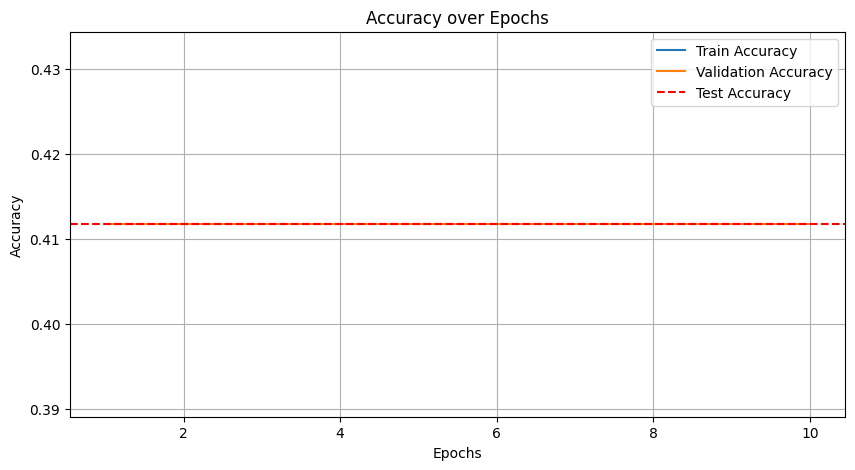

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(512 * 7 * 7, 256)  # 입력 차원 수정 필요
        self.fc2 = nn.Linear(256, 1)  # Binary classification (output: 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits

# 학습 및 검증 함수
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.view(-1, 1))  # Outputs shape: [batch_size, 1]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels.view(-1, 1)).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def validate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1))

            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def calculate_auc(model, data_loader, device, num_classes=3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # 각 클래스에 대한 확률값을 구하기 위해 소프트맥스 적용
            preds = torch.softmax(outputs, dim=1).cpu().numpy()  # 클래스 확률
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # 레이블을 이진 형식으로 변환
    all_labels = label_binarize(np.array(all_labels), classes=[0, 1, 2])  # 다중 클래스 레이블을 이진화

    # ROC AUC 점수 계산
    auc = roc_auc_score(all_labels, all_preds, average='macro', multi_class='ovr')
    return auc


# 학습 루프
num_epochs = 10
train_accuracies = []
val_accuracies = []
test_accuracies = []  # 테스트 정확도 리스트 초기화

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, device)
    val_auc = calculate_auc(model, val_loader, device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}')

# 테스트셋에서 최종 성능 평가
test_loss, test_acc = validate_epoch(model, test_loader, device)
test_auc = calculate_auc(model, test_loader, device)

print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

# Test accuracy 계산
test_accuracies.append(test_acc)  # 테스트 정확도를 리스트에 추가

# 학습, 검증, 테스트 정확도 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [31]:
from collections import Counter

def count_labels(labels):
    label_counts = Counter(labels)
    return label_counts

label_counts = count_labels(train_labels)
print("Label counts:", label_counts)

Label counts: Counter({0: 42, 0.5: 42, 1: 18})


In [26]:
# 최종 데이터셋 출력
train_dementia_count = sum([1 for label in train_labels if label == 1])
train_mild_dementia_count = sum([1 for label in train_labels if label == 0.5])
train_non_dementia_count = len(train_labels) - train_dementia_count - train_mild_dementia_count

val_dementia_count = sum([1 for label in val_labels if label == 1])
val_mild_dementia_count = sum([1 for label in val_labels if label == 0.5])
val_non_dementia_count = len(val_labels) - val_dementia_count - val_mild_dementia_count

test_dementia_count = sum([1 for label in test_labels if label == 1])
test_mild_dementia_count = sum([1 for label in test_labels if label == 0.5])
test_non_dementia_count = len(test_labels) - test_dementia_count - test_mild_dementia_count

print(f"Train set: {len(train_subjects)} subjects (Dementia: {train_dementia_count}, Mild Dementia: {train_mild_dementia_count}, Non-dementia: {train_non_dementia_count})")
print(f"Validation set: {len(val_subjects)} subjects (Dementia: {val_dementia_count}, Mild Dementia: {val_mild_dementia_count}, Non-dementia: {val_non_dementia_count})")
print(f"Test set: {len(test_subjects)} subjects (Dementia: {test_dementia_count}, Mild Dementia: {test_mild_dementia_count}, Non-dementia: {test_non_dementia_count})")

Train set: 102 subjects (Dementia: 18, Mild Dementia: 42, Non-dementia: 42)
Validation set: 34 subjects (Dementia: 6, Mild Dementia: 14, Non-dementia: 14)
Test set: 34 subjects (Dementia: 6, Mild Dementia: 14, Non-dementia: 14)


# Augmentation (치매군 24장 증강)

In [4]:
import cv2
import random

def grid_distortion(image, num_steps=64, distort_limit=0.02, interpolation=cv2.INTER_NEAREST):
    h, w = image.shape[:2]
    
    # Grid cells의 크기 계산
    step_x = w // num_steps
    step_y = h // num_steps
    
    # 왜곡을 위한 random distortion 값 생성
    steps_x = [1 + random.uniform(-distort_limit, distort_limit) for _ in range(num_steps + 1)]
    steps_y = [1 + random.uniform(-distort_limit, distort_limit) for _ in range(num_steps + 1)]

    # 변형된 좌표를 계산
    map_x = np.zeros((h, w), dtype=np.float32)
    map_y = np.zeros((h, w), dtype=np.float32)
    
    for i in range(num_steps):
        for j in range(num_steps):
            # 각 grid cell의 좌표 변형
            x1 = j * step_x
            x2 = (j + 1) * step_x
            y1 = i * step_y
            y2 = (i + 1) * step_y
            
            map_x[y1:y2, x1:x2] = np.linspace(x1, x2, step_x) * steps_x[j]
            map_y[y1:y2, x1:x2] = np.linspace(y1, y2, step_y) * steps_y[i]

    # 좌표 변환을 사용하여 왜곡된 이미지 생성
    distorted_image = cv2.remap(image, map_x, map_y, interpolation, borderMode=cv2.BORDER_REFLECT_101)

    # 최종 결과 약간 흐리게 조정 (선택 사항)
    # distorted_image = cv2.GaussianBlur(distorted_image, (5, 5), 0)

    return distorted_image

In [5]:
def augment_images_with_grid_distortion(images, label, num_images_to_augment=24):
    aug1_dementias = []
    aug1_dementias_labels = []  # 증강된 이미지의 라벨 저장 리스트
    #aug1_dementias_subjects = []  # 증강된 이미지의 subject 정보를 저장할 리스트

    # 라벨이 1 이상인 이미지 인덱스 추출
    labels_array = np.array(label)
    indices_to_augment = np.where(labels_array >= 1)[0]

     # 1 이상인 라벨을 가진 이미지를 한 번씩 선택
    selected_indices = np.random.choice(indices_to_augment, size=len(indices_to_augment), replace=False)

    # 선택된 각 이미지에 대해 그리드 왜곡을 적용
    for index in selected_indices:
        original_image = images[index]
        # 기본 강도의 왜곡 적용
        aug_image = grid_distortion(original_image)
        aug1_dementias.append(aug_image)
        aug1_dementias_labels.append(labels[index])  # 라벨 추가

    # 추가로 중복 선택된 이미지 6개에 대해 더 강한 그리드 왜곡 적용
    num_images_to_augment_strong = num_images_to_augment - len(selected_indices)  # 추가로 생성할 이미지 수
    strong_indices = np.random.choice(selected_indices, size=num_images_to_augment_strong, replace=True)

    for index in strong_indices:
        original_image = images[index]
        # 강한 그리드 왜곡을 적용
        aug_image_strong = grid_distortion(original_image, distort_limit=0.01)  # 왜곡 강도를 0.01로 설정
        aug1_dementias.append(aug_image_strong)
        aug1_dementias_labels.append(labels[index])  # 라벨 추가

    return np.array(aug1_dementias), np.array(aug1_dementias_labels)

train_subjects_masked = [subject for subject in train_subjects if subject in transverse_images_masked]
train_labels_masked = [df[df['ID'] == subject]['CDR'].values[0] for subject in train_subjects_masked]

# 이미지 증강
aug1_dementias, aug1_dementias_labels = augment_images_with_grid_distortion(train_transverse_masked, train_labels_masked, num_images_to_augment=24)

# 결과 확인
print(f"Original images shape: {train_transverse_masked.shape}")
print(f"Augmented images shape: {aug1_dementias.shape}")

Original images shape: (102, 224, 224, 3)
Augmented images shape: (24, 224, 224, 3)


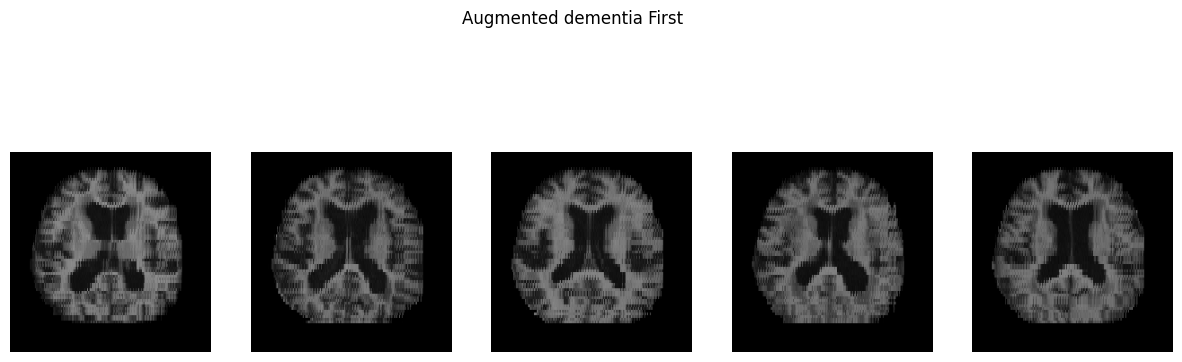

In [6]:
import matplotlib.pyplot as plt
def plot_imgs(images, title="Images"):
    num_images = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')  # 흑백 이미지인 경우 cmap='gray'를 사용
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_imgs(aug1_dementias[:5], title="Augmented dementia First")

In [6]:
def combine_datasets(original_images, augmented_images):
    combined_images = np.concatenate((original_images, augmented_images), axis=0)
    return combined_images

# aug1_dementias를 numpy 배열로 변환
aug1_dementias_np = np.array(aug1_dementias)

# 원래 데이터셋과 증강된 데이터셋 결합
train_transverse_masked2 = combine_datasets(train_transverse_masked, aug1_dementias_np)

# aug1_dementias의 라벨을 1로 설정 (치매군)
aug1_dementias_labels = np.ones(aug1_dementias_np.shape[0])

# 원래 라벨과 증강된 라벨을 결합
train_transverse_masked2_labels = np.concatenate((train_labels_masked, aug1_dementias_labels), axis=0)

# 결과 확인
print(f"Combined dataset shape: {train_transverse_masked2.shape}")
print(f"Combined labels shape: {train_transverse_masked2_labels.shape}")

Combined dataset shape: (126, 224, 224, 3)
Combined labels shape: (126,)


# Augmentation (모두 증강)

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class RandomCropAndPad:
    def __init__(self, crop_size=(180, 180), final_size=(224, 224), padding_value=0):
        self.crop_size = crop_size
        self.final_size = final_size
        self.padding_value = padding_value

    def __call__(self, image):
        h, w, _ = image.shape
        top = random.randint(0, h - self.crop_size[0])
        left = random.randint(0, w - self.crop_size[1])
        cropped_image = image[top:top + self.crop_size[0], left:left + self.crop_size[1]]
        
        padded_image = cv2.copyMakeBorder(
            cropped_image,
            top=(self.final_size[0] - self.crop_size[0]) // 2,
            bottom=(self.final_size[0] - self.crop_size[0] + 1) // 2,
            left=(self.final_size[1] - self.crop_size[1]) // 2,
            right=(self.final_size[1] - self.crop_size[1] + 1) // 2,
            borderType=cv2.BORDER_CONSTANT,
            value=[self.padding_value] * 3
        )

        return padded_image

class BrainMRIDataset(Dataset):
    def __init__(self, images, labels, crop_size=(180, 180), final_size=(224, 224), padding_value=0):
        self.images = images
        self.labels = labels
        self.augment = RandomCropAndPad(crop_size, final_size, padding_value)

    def __len__(self):
        return len(self.images)  # 전체 이미지 수 반환

    def __getitem__(self, idx):
        image = self.images[idx]  # 인덱스에 해당하는 이미지 가져옴
        label = self.labels[idx]  # 인덱스에 해당하는 라벨 가져옴

        # Random crop and pad 적용
        augmented_image = self.augment(image)

        # 이미지 채널 차원 변경 (H, W, C) -> (C, H, W) for PyTorch compatibility
        augmented_image = np.transpose(augmented_image, (2, 0, 1))

        # Convert to tensor
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return augmented_image, label

def augment_images_for_each_label(images, labels, num_augmentations=8):
    augmented_images = []
    augmented_labels = []

    unique_labels = np.unique(labels)

    for label in unique_labels:
        # 해당 라벨을 가진 이미지 인덱스 추출
        indices = np.where(labels == label)[0]
        for index in indices:
            original_image = images[index]
            # 증강된 이미지 생성
            for _ in range(num_augmentations):
                # 랜덤 크롭 및 패딩 적용
                augmented_image = RandomCropAndPad()(original_image)
                augmented_images.append(augmented_image)
                augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# 이미지와 라벨을 가지고 증강 실행
augmented_images, augmented_labels = augment_images_for_each_label(train_transverse_masked2, train_transverse_masked2_labels, num_augmentations=8)

# 데이터셋에 추가할 수 있는 BrainMRIDataset 클래스 초기화
combined_images = np.concatenate((train_transverse_masked2, augmented_images), axis=0)
combined_labels = np.concatenate((train_transverse_masked2_labels, augmented_labels), axis=0)

# 새로운 데이터셋 초기화
dataset = BrainMRIDataset(combined_images, combined_labels)

# 결과 확인
print(f"Combined dataset size: {len(dataset)}")

Combined dataset size: 1134


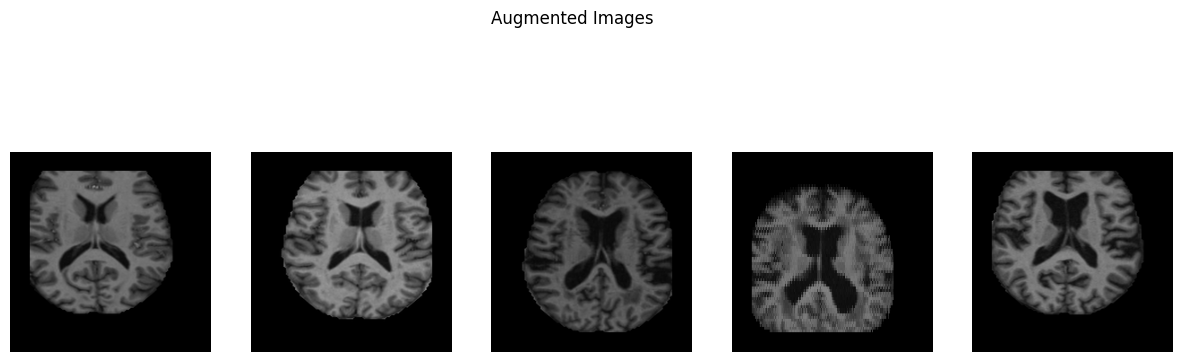

In [9]:
import matplotlib.pyplot as plt
def plot_imgs(images, title="Images", num_images=5):
    if len(images) == 0:
        print("No images to display.")
        return

    # 무작위로 num_images 개의 인덱스 선택
    random_indices = np.random.choice(len(images), size=min(num_images, len(images)), replace=False)

    plt.figure(figsize=(15, 5))
    for i, index in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index])  # 이미지 표시
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# augmented_images는 (num_images, height, width, channels) 형태여야함
plot_imgs(augmented_images, title="Augmented Images", num_images=5)

In [8]:
from collections import Counter

def count_labels(labels):
    label_counts = Counter(labels)
    return label_counts

label_counts = count_labels(combined_labels)
print("Label counts:", label_counts)

Label counts: Counter({0.0: 378, 0.5: 378, 1.0: 369, 2.0: 9})


# 모델링을 위한 데이터셋 준비

In [12]:
# val_transverse_masked에서 라벨 추출
val_labels_masked = []

for i, subject in enumerate(val_subjects):
    if i < len(val_transverse_masked):  # 범위 체크
        # 해당 subject에 대한 라벨을 df에서 찾기
        label = df[df['ID'] == subject]['CDR'].values
        if len(label) > 0:  # 라벨이 존재할 경우
            val_labels_masked.append(label[0])

# 라벨의 개수 확인
num_val_labels_masked = len(val_labels_masked)
print("Number of labels extracted from val_transverse_masked:", num_val_labels_masked)

Number of labels extracted from val_transverse_masked: 34


In [9]:
# 라벨 확인하기
print("Train Labels:", np.unique(combined_labels))  # 훈련 레이블 확인
print("Val Labels:", np.unique(val_labels))      # 검증 레이블 확인
print("Test Labels:", np.unique(test_labels))    # 테스트 레이블 확인

Train Labels: [0.  0.5 1.  2. ]
Val Labels: [0.  0.5 1. ]
Test Labels: [0.  0.5 1. ]


In [10]:
# 검증 레이블을 다시 설정하기
train_labels_corrected = []
for label in combined_labels:
    if label == 0.0:
        train_labels_corrected.append(0)
    elif label == 0.5:
        train_labels_corrected.append(1) 
    elif label >= 1.0:
        train_labels_corrected.append(2)

# 수정된 검증 레이블 확인
print("Corrected trian Labels:", np.unique(train_labels_corrected))

Corrected trian Labels: [0 1 2]


In [11]:
# 검증 레이블을 다시 설정하기
val_labels_corrected = []
for label in val_labels:
    if label == 0.0:
        val_labels_corrected.append(0)
    elif label == 0.5:
        val_labels_corrected.append(1) 
    elif label >= 1.0:
        val_labels_corrected.append(2)

# 수정된 검증 레이블 확인
print("Corrected Val Labels:", np.unique(val_labels_corrected))

Corrected Val Labels: [0 1 2]


In [12]:
test_labels_corrected = []
for label in test_labels:
    if label == 0.0:
        test_labels_corrected.append(0)
    elif label == 0.5:
        test_labels_corrected.append(1) 
    elif label >= 1.0:
        test_labels_corrected.append(2)

# 수정된 검증 레이블 확인
print("Corrected Val Labels:", np.unique(test_labels_corrected))

Corrected Val Labels: [0 1 2]


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if isinstance(image, tuple):
            images = [img for img in image if isinstance(img, torch.Tensor) and img.numel() > 0]
            if not images:
                raise ValueError(f"No valid images found at index {idx}.")

            first_shape = images[0].shape
            images = [img for img in images if img.shape == first_shape]

            if images:
                image = torch.stack(images).mean(dim=0)
            else:
                raise ValueError(f"No valid images with consistent shape found at index {idx}.")
        
        # 이미지가 이미 torch.Tensor인 경우 clone().detach() 사용
        if isinstance(image, torch.Tensor):
            image = image.clone().detach().float()
        else:
            image = torch.tensor(image, dtype=torch.float32)

        # 이미지가 3D일 경우 (H, W, C)에서 (C, H, W)로 변환
        if image.ndim == 3 and image.shape[2] == 3:  # (H, W, C) -> (C, H, W)
            image = image.permute(2, 0, 1)

        # 라벨을 텐서로 변환
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

# 데이터셋 생성
train_dataset = CustomDataset(dataset, train_labels_corrected) #combined_labels #train_labels_corrected
val_dataset = CustomDataset(val_transverse_masked, val_labels_corrected)
test_dataset = CustomDataset(test_transverse_masked, test_labels_corrected)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
from collections import Counter

# 레이블 분포 확인
combined_labels = []
for _, labels in train_loader:
    combined_labels.extend(labels.cpu().numpy())

label_counts = Counter(combined_labels)
print("레이블 분포:", label_counts)

레이블 분포: Counter({2.0: 378, 0.0: 378, 1.0: 378})


#### 간단 CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(512 * 7 * 7, 256)  # 입력 차원 수정 필요
        self.fc2 = nn.Linear(256, 1)  # Binary classification (output: 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits

# 학습 및 검증 함수
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.view(-1, 1))  # Outputs shape: [batch_size, 1]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels.view(-1, 1)).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def validate_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1))

            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels.view(-1, 1)).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def calculate_auc(model, data_loader, device, num_classes=3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # 각 클래스에 대한 확률값을 구하기 위해 소프트맥스 적용
            preds = torch.softmax(outputs, dim=1).cpu().numpy()  # 클래스 확률
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # 레이블을 이진 형식으로 변환
    all_labels = label_binarize(np.array(all_labels), classes=[0, 1, 2])  # 다중 클래스 레이블을 이진화

    # ROC AUC 점수 계산
    auc = roc_auc_score(all_labels, all_preds, average='macro', multi_class='ovr')
    return auc


# 학습 루프
num_epochs = 10
train_accuracies = []
val_accuracies = []
test_accuracies = []  # 테스트 정확도 리스트 초기화

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, device)
    val_auc = calculate_auc(model, val_loader, device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}')

# 테스트셋에서 최종 성능 평가
test_loss, test_acc = validate_epoch(model, test_loader, device)
test_auc = calculate_auc(model, test_loader, device)

print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

# Test accuracy 계산
test_accuracies.append(test_acc)  # 테스트 정확도를 리스트에 추가

# 학습, 검증, 테스트 정확도 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')  # 테스트 정확도를 수평선으로 표시
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Epoch 1/10
Train Loss: 0.0378, Train Accuracy: 0.3333
Validation Loss: 12.1626, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 2/10
Train Loss: 12966.2561, Train Accuracy: 0.3333
Validation Loss: 84810.4375, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 3/10
Train Loss: -2047594.9019, Train Accuracy: 0.3333
Validation Loss: 15539198.6667, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 4/10
Train Loss: -221372325.7042, Train Accuracy: 0.3333
Validation Loss: 4088283477.3333, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 5/10
Train Loss: -5364222573.0704, Train Accuracy: 0.3333
Validation Loss: 26924097536.0000, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 6/10
Train Loss: -78335713936.2254, Train Accuracy: 0.3333
Validation Loss: 217917904213.3333, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 7/10
Train Loss: -569133605902.4225, Train Accuracy: 0.3333
Validation Loss: 616821926570.6666, Validation Accuracy: 0.4118, AUC: 0.5000
Epoch 8/10
Train Loss: -2816346899124.2817, Train Accu

NameError: name 'plt' is not defined

# CNN 기반 모델 앙상블
Soft Voting: 각 모델이 출력한 클래스 확률의 평균을 내어 최종 클래스를 결정    
Hard Voting: 각 모델이 예측한 클래스 중 가장 많이 나온 클래스를 최종 클래스 예측값으로 사용

In [14]:
print("y_train unique values:", np.unique(combined_labels))

y_train unique values: [0.  0.5 1.  2. ]


In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

class KerasVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X):
        # 각 모델의 예측을 수집
        predictions = [np.argmax(model.predict(X), axis=1) for model in self.models]
        predictions = np.array(predictions)  # (n_models, n_samples)
        
        # 각 샘플에 대해 다수결로 최종 예측 결정
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        
        return majority_vote

def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_simple_cnn_model(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 훈련 데이터 준비 (X_train: MRI 이미지, y_train: 클래스 레이블)
X_train = combined_images  # (n_samples, 224, 224, 3) 크기의 MRI 이미지 데이터

# 모델 생성
vgg_model = create_vgg_model()
resnet_model = create_resnet_model()
simple_cnn_model = create_simple_cnn_model()
#densenet_model = create_densenet_model()


# KerasVotingClassifier 생성 (하드 보팅)
voting_clf = KerasVotingClassifier(models=[vgg_model, resnet_model, simple_cnn_model])

# 모델 학습
voting_clf.fit(X_train, y_train)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv1/Relu' defined at (most recent call last):
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\pc\AppData\Local\Temp\ipykernel_27640\2797714139.py", line 79, in <module>
      voting_clf.fit(X_train, y_train)
    File "C:\Users\pc\AppData\Local\Temp\ipykernel_27640\2797714139.py", line 15, in fit
      model.fit(X, y)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\pc\anaconda3\envs\braineewha\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv1/Relu'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5908]

In [ ]:
# Validation 데이터를 준비
X_val = val_transverse_masked  # (n_samples_val, 224, 224, 3) 크기의 검증 이미지 데이터
# y_val = val_labels  # (n_samples_val,) 크기의 검증 라벨 데이터

# 모델 학습 중 검증 세트의 성능 확인
voting_clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

In [ ]:
# Model Checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping 및 ModelCheckpoint 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# 모델 훈련 시 콜백 추가
voting_clf.fit(X_train, y_train, validation_data=(X_val, y_val), 
               epochs=50, callbacks=[early_stopping, model_checkpoint])

In [ ]:
# Test 데이터를 준비
X_test = test_transverse_masked  # (n_samples_test, 224, 224, 3) 크기의 테스트 이미지 데이터
# y_test = test_labels  # (n_samples_test,) 크기의 테스트 라벨 데이터

# 최종 학습된 모델로 테스트 세트 성능 평가
test_loss, test_accuracy = voting_clf.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

#### 계획
Cross Entropy Loss 대신 Focal Loss 사용    
Cross Validation

# 모델 후보

In [ ]:
def create_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Model

from keras.callbacks import EarlyStopping

epochs=200
batch_size=32
learning=0.0001
early_stopping= EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 클래스가 3개라면
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # 라벨이 0, 1, 2일 경우
              metrics=['accuracy'])

# 모델 요약 출력
model.summary()

In [ ]:
# 모델 학습
model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# ResNet50

In [18]:
# 모델 정의 (ResNet50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 장치 설정
model = models.resnet50(pretrained=False)  # pretrained=False로 설정
model.fc = nn.Linear(model.fc.in_features, 3)  # 3개의 클래스를 위한 출력
model = model.to(device)  # GPU를 사용할 경우 device 설정

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # 라벨 변환 적용
            #converted_labels = convert_labels(labels)  # GPU에서 변환 #문제 시 삭제
            labels = convert_labels(labels).long()  # CrossEntropyLoss를 위해 정수형 변환
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # CrossEntropyLoss 계산
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 훈련 시작
train_model(model, train_loader, criterion, optimizer, num_epochs=8)

Epoch [1/8], Loss: 1.2730
Epoch [2/8], Loss: 0.5062
Epoch [3/8], Loss: 0.9239
Epoch [4/8], Loss: 0.8277
Epoch [5/8], Loss: 0.7337
Epoch [6/8], Loss: 0.5822
Epoch [7/8], Loss: 0.8285
Epoch [8/8], Loss: 0.5230


Validation AUC: 0.6913


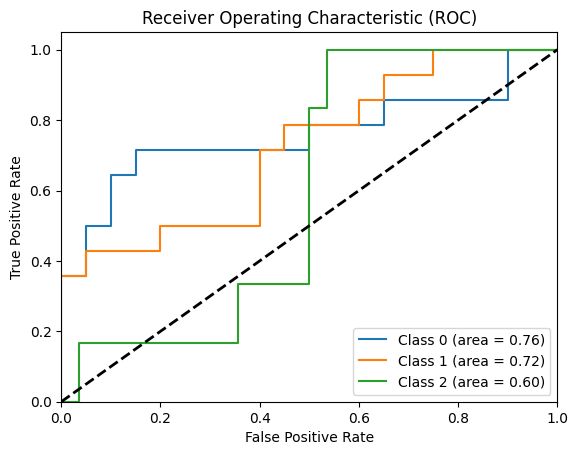

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn.functional as F

val_dataset = BrainMRIDataset(val_transverse_masked, val_labels_masked, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def validate_model(model, val_loader, criterion):
    model.eval()  # 평가 모드로 설정
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # 라벨 변환 적용 (0, 1, 2로 유지)
            labels = convert_labels(labels).long()

            # 모델로 예측
            outputs = model(images)
            
            # 소프트맥스 확률 계산
            probs = F.softmax(outputs, dim=1)  # 각 클래스에 대한 확률
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
    
    # 모든 라벨과 확률을 하나의 배열로 합침
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    # AUC 계산 (multi-class에 대해 one-vs-rest 방식으로 계산)
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    print(f'Validation AUC: {auc_score:.4f}')
    return all_labels, all_probs, auc_score

def plot_roc_curve(all_labels, all_probs):
    # One-vs-Rest 방식으로 각 클래스별 ROC 곡선을 그림
    for i in range(3):
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(all_labels == i, all_probs[:, i]):.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 대각선 (랜덤 추측) 선
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

# 모델 훈련 후 검증 및 AUC 계산
all_labels, all_probs, auc_score = validate_model(model, val_loader, criterion)

# ROC Curve 그리기
plot_roc_curve(all_labels, all_probs)
